In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch import optim
import torch.nn.functional as F
import pickle
import seaborn as sns
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
import gym
import minigrid
from minigrid.envs.doorkey import DoorKeyEnv
from minigrid.envs.crossing import CrossingEnv
from minigrid.core.world_object import Goal, Lava
from minigrid.wrappers import ObservationWrapper
from gym.envs.registration import registry, register
from typing_extensions import Self
from dataclasses import dataclass
from typing import Any
from copy import deepcopy
from collections import deque

/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                gae_lambda=0.95,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=True,
                use_gae=True,
                importance_sampling_clip=2.0,
                bad_fit_threshold=0.8,
                bad_fit_increment=None,
                replay_buffer_capacity=10,
                large_buffer_capacity=20):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.use_gae = use_gae # whether to use GAE or not.
        self.importance_sampling_clip = importance_sampling_clip # importance sampling clip threshold
        self.bad_fit_threshold = bad_fit_threshold # threshold for bad fit.
        if bad_fit_increment is None:
            bad_fit_increment = (1.0 - bad_fit_threshold) / replay_buffer_capacity
        self.bad_fit_increment = bad_fit_increment # increment for bad fit.
        self.replay_buffer_capacity = replay_buffer_capacity # capacity of replay buffer.
        self.large_buffer_capacity = large_buffer_capacity # capacity of large replay buffer.

In [3]:
# Auxiliary functions

def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", get_device())

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class MyDoorKeyEnv(DoorKeyEnv):
    def __init__(self, size):
        self.render_mode = "rgb_array"
        super().__init__(size=size)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]
    
def get_door_key_env(size):
    """
    Returns a DoorKeyEnv environment with the given size.
    """
    env = MyDoorKeyEnv(size=size)
    env = ImgObsWrapper(env)

    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
    #            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
    #            tile_size (int): How many pixels will form a tile from the NxM grid.
    #            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    # show an image to the notebook.
    plt.imshow(frame)

    return env

class MyCrossingEnv(CrossingEnv):
    def __init__(self, size, obstacle_type):
        """
        size: odd number
        obstacle_type: 
            - Lava: episode ends when agent steps on lava.
            - anything else: lava is wall
        """
        self.render_mode = "rgb_array"
        super().__init__(size=size, obstacle_type=obstacle_type)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

def get_crossing_env(size, obstacle_type):
    """
    Returns a Crossing environment with the given size.
    """
    env = MyCrossingEnv(size=size, obstacle_type=obstacle_type)
    env = ImgObsWrapper(env)

    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
    #            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
    #            tile_size (int): How many pixels will form a tile from the NxM grid.
    #            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    # show an image to the notebook.
    plt.imshow(frame)

    return env

Device: cpu


In [4]:
class ACModel(nn.Module):
    def __init__(self, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 7)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        obs = torch.tensor(obs).float() # convert to float tensor
        if len(obs.shape) == 3:
            obs = obs.unsqueeze(0) # add batch dimension if not already there
            
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value

class CuriosityMachine:
    def __init__(self, coef, model:nn.Module, num_train:int=5, args:Config=None):
        """
        A machine that determine curiosity of (s, a)

        Parameters:
            coef: how fast machine learns
            model: a model pi(a | s) without critic
            train_num: how many times to loop optimizer
        """
        if args is None:
            args = Config()
        self.args = args
        self.ceof = coef
        self.model = model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.num_train = num_train
        self.mean = 1.0
    
    def _update_mean(self, target:float) -> None:
        self.mean = 0.95 * self.mean + 0.05 * target
    
    def update_parameters(self, sb:list) -> float:
        """
        Update model parameters and mean.

        Returns:
            MSE after num_train updates.
        """
        for i in range(self.num_train):
            self.optim.zero_grad()
            dist, _ = self.model(sb['obs'])
            logps = dist.log_prob(sb['action'])
            loss = torch.mean((logps + np.log(7)) ** 2)
            if i == 0:
                # update mean only once
                with torch.no_grad():
                    target = torch.mean(torch.abs(logps + np.log(7)))
                self._update_mean(target.item())
            loss.backward(retain_graph=True)
            self.optim.step()

        return loss.item()

    def modify_rs(self, sb:list, factor:float=0.1) -> None:
        """
        Modify rewards by adding curiosity bonus.
        Add a curiosity_reward key to sb.
        """
        rewards = sb['reward']
        with torch.no_grad():
            dist, _ = self.model(sb['obs'])
        logps = dist.log_prob(sb['action'])
        curiosity = torch.abs(logps + np.log(7))
        curiosity /= self.mean
        curiosity = torch.clamp(curiosity, 0.0, 5.0)
        curiosity *= factor
        rewards += curiosity

        sb['curiosity_reward'] = rewards
        
class Machine:
    def __init__(self, entropy_coef, init_model:nn.Module, args:Config=None, smart_discard=False, curiosity_factor:float=0.1):
        """
        A Machine object consists of a Model and its entropy_coef

        Args:
            entropy_coef: Entropy coefficient.
            init_model: Initial model.
            args
        """
        if args is None:
            self.args = Config()
        else:
            self.args = args

        self.model = init_model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.coef = entropy_coef
        self.smart_discard = smart_discard
        self.curiosity_factor = curiosity_factor

    def copy_model(self, other_model:nn.Module) -> None:
        """
        Copy state dict from 'model'. Reset rs.
        """
        state_dict = other_model.state_dict()
        for key, v in state_dict.items():
            if key in self.model.state_dict():
                self.model.state_dict()[key].copy_(v)

    def copy_machine(self, other:Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        self.copy_model(other.model)

    def _compute_discounted_return(self, rewards):
        """
            rewards: reward obtained at timestep.  Shape: (T,)
            discount: discount factor. float

        ----
        returns: sum of discounted rewards. Shape: (T,)
        """
        device = get_device()
        returns = torch.zeros(*rewards.shape, device=device)

        R = 0
        for t in reversed(range((rewards.shape[0]))):
            R = rewards[t] + self.args.discount * R
            returns[t] = R
        return returns

    def _compute_advantage_gae(self, values, rewards, T):
        """
        Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

        values: value at each timestep (T,)
        rewards: reward obtained at each timestep.  Shape: (T,)
        T: the number of frames, float
        gae_lambda: hyperparameter, float
        discount: discount factor, float

        -----

        returns:

        advantages : tensor.float. Shape [T,]

                    gae advantage term for timesteps 0 to T

        """
        advantages = torch.zeros_like(values)
        for i in reversed(range(T)):
            next_value = values[i+1]
            next_advantage = advantages[i+1]

            delta = rewards[i] + self.args.discount * next_value  - values[i]
            advantages[i] = delta + self.args.discount * self.args.gae_lambda * next_advantage
        return advantages[:T]
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction
            with torch.no_grad():
                dist, value = self.model(obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())

            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)

            total_return += reward
            T += 1

            if done or T >= MAX_FRAMES_PER_EP-1:
                break

        success = (total_return > 0.1)
        
        discounted_reward = self._compute_discounted_return(rewards[:T])
        exps = dict(
            obs = torch.tensor(np.array(obss[:T]), device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T,
            'success': success
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, dist:Categorical, factors, indices, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        policy_loss_tensor = factors * ppo_loss + self.coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl
    
    def _compute_value_loss(self, values, returns):
        value_loss = torch.mean((values - returns) ** 2)

        return value_loss

    def update_parameters(self, sb, update_v=True, curiositor:CuriosityMachine=None):
        MAX_FRAMES_PER_EP = 300
        T = sb['T']
        with torch.no_grad():
            dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action'])
        init_logp = sb['log_prob']
        if curiositor is None:
            not_full_reward = sb['reward']
        else:
            curiositor.modify_rs(sb, factor=self.curiosity_factor)
            not_full_reward = sb['curiosity_reward']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=get_device())], dim=0)
        full_reward = torch.cat([not_full_reward, torch.zeros((MAX_FRAMES_PER_EP - len(not_full_reward), ), device=get_device())], dim=0)


        if self.args.use_gae:
            advantage = self._compute_advantage_gae(values_extended, full_reward, T)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            dist, values = self.model(sb['obs'])
            values = values.reshape(-1)
            # policy loss
            factors = torch.exp(old_logp - init_logp)
            if self.smart_discard:
                indices = (factors < self.args.importance_sampling_clip) & (torch.exp(old_logp) < (1.0 + torch.exp(init_logp - old_logp)) / 2)
            else:
                indices = factors < self.args.importance_sampling_clip
            fit = torch.mean(indices.to(torch.float32))

            loss_pi, approx_kl = self._compute_policy_loss_ppo(dist, factors, indices, old_logp, sb['action'], advantage)
            if update_v:
                loss_v = self._compute_value_loss(values, sb['discounted_reward'])
            else:
                loss_v = 0.0

            if i == 0:
                policy_loss = loss_pi
                value_loss = loss_v

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
            "fit": fit.item()
        }

        return logs
    
    def decrease_prob(self, sb, lr=0.1) -> None:
        self.optim.zero_grad()

        dist, _ = self.model(sb['obs'])
        dist: Categorical
        logps = dist.log_prob(sb['action'])

        loss = lr * torch.mean(logps)
        loss.backward()
        self.optim.step()

class RandomMachine:
    def __init__(self, args:Config=None):
        self.args = args if args is not None else Config()

    def _compute_discounted_return(self, rewards):
        """
            rewards: reward obtained at timestep.  Shape: (T,)
            discount: discount factor. float

        ----
        returns: sum of discounted rewards. Shape: (T,)
        """
        device = get_device()
        returns = torch.zeros(*rewards.shape, device=device)

        R = 0
        for t in reversed(range((rewards.shape[0]))):
            R = rewards[t] + self.args.discount * R
            returns[t] = R
        return returns
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()
        num_actions = env.action_space.n

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction
            action = torch.randint(num_actions, size=(1,)).to(device)

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())

            # Update experiences values
            actions[T] = action
            values[T] = 0
            rewards[T] = reward
            log_probs[T] = -np.log(num_actions)

            total_return += reward
            T += 1

            if done or T >= MAX_FRAMES_PER_EP-1:
                break

        success = (total_return > 0.1)
        
        discounted_reward = self._compute_discounted_return(rewards[:T])
        exps = dict(
            obs = torch.tensor(np.array(obss[:T]), device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T,
            'success': success
        }

        return exps, logs


In [5]:
class PPO:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The PPO agent.
        """

        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True)

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)
    
    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float]]:
        """
        Train the PPO agent.

        Returns:
            num_frames, smooth_rs
        """
        
        print(f'Start! Agent: PPO.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs

class RRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True)

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args)

        m2 = ACModelClass(use_critic=False)
        m3 = ACModelClass(use_critic=False)
        m4 = ACModelClass(use_critic=False)

        self.explorer_random = Machine(0.03, m2, args)
        self.explorer_thirsty = Machine(0.02, m3, args)
        self.explorer_thirsty.copy_machine(self.exploiter)

        self.temp_machine = Machine(0.01, m3, args)
        self.explorer_bengbuzhu = Machine(0.5, m4, args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)

        return fit

    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)


    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: RRR.')
        RANDOM_MODE = 0 # Bengbuzhu explores
        EXPLORE_MODE = 1
        EXPLOIT_MODE = 2
        mode = RANDOM_MODE

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        larger_buffer_r = []
        buffer_r = []
        buffer_no_r = []
        fits = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            if mode == RANDOM_MODE:
                exps, logs1 = self.explorer_bengbuzhu.collect_experiences(self.env)
                self.explorer_bengbuzhu.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

            elif mode == EXPLORE_MODE:
                if np.random.rand() < 0.5:
                    m = self.explorer_random
                else:
                    m = self.explorer_thirsty

                exps, logs1 = m.collect_experiences(self.env)

                m.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

                if len(larger_buffer_r) >= 1:
                    self._replay(self.explorer_thirsty, larger_buffer_r, cutoff=0.0)

            elif mode == EXPLOIT_MODE:
                exps, logs1 = self.exploiter.collect_experiences(self.env)

                logs2 = self.exploiter.update_parameters(exps)

                assert len(buffer_r) > 0, f'buffer_r should not be empty.'

                cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)

                if not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                    fit = self._replay(self.exploiter, buffer_r, cutoff)
                    fits.append(fit)

                if len(buffer_r) == 0:
                    print(f'At episode {update}, we lost all data in replay buffer...')
                    mode = EXPLORE_MODE
                    self.explorer_thirsty.copy_machine(self.exploiter)
                    self.explorer_random.copy_machine(self.temp_machine)
                    self.temp_machine.copy_machine(self.exploiter)

            else:
                raise ValueError(f'Invalid mode: {mode}')

            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                if mode == RANDOM_MODE:
                    print(f'First successful data collected at episode {update}! We will be accelerating.')
                elif mode == EXPLORE_MODE:
                    if m is self.explorer_random:
                        info_print = 'random explorer'
                    elif m is self.explorer_thirsty:
                        info_print = 'thirsty explorer'
                    else:
                        raise ValueError(f'Invalid explorer: {m}')
                    
                    print(f'At episode {update}, {info_print} collected a successful data.')
                elif mode == EXPLOIT_MODE:
                    pass
                else:
                    raise ValueError(f'Invalid mode: {mode}')
                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)
                self._add_sb_to_buffer(exps, larger_buffer_r, self.exploiter.args.large_buffer_capacity)
                mode = EXPLOIT_MODE
            else:
                self._add_sb_to_buffer(exps, buffer_no_r, self.exploiter.args.replay_buffer_capacity)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                    is_solved = True
                    break
            if num_frames >= max_frames:
                break

        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits

class BetaRRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True)

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args, smart_discard=True)

        m2 = ACModelClass(use_critic=False)
        m3 = ACModelClass(use_critic=False)
        m4 = ACModelClass(use_critic=False)

        self.explorer_random = Machine(0.03, m2, args)
        self.explorer_thirsty = Machine(0.02, m3, args)

        self.explorer_bengbuzhu = Machine(0.5, m4, args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)

        return fit

    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)

    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: beta RRR.')
        RANDOM_MODE = 0
        EXPLORE_MODE = 1
        EXPLOIT_MODE = 2
        mode = RANDOM_MODE

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        larger_buffer_r = []
        buffer_r = []
        buffer_no_r = []
        fits = []
        cutoff_lock = True

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            if mode == RANDOM_MODE:
                exps, logs1 = self.explorer_bengbuzhu.collect_experiences(self.env)
                self.explorer_bengbuzhu.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

            elif mode == EXPLORE_MODE:
                if np.random.rand() < 0.5:
                    m = self.explorer_random
                else:
                    m = self.explorer_thirsty

                exps, logs1 = m.collect_experiences(self.env)

                m.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

                if len(larger_buffer_r) >= 1:
                    self._replay(self.explorer_thirsty, larger_buffer_r, cutoff=0.0)

            elif mode == EXPLOIT_MODE:
                exps, logs1 = self.exploiter.collect_experiences(self.env)

                logs2 = self.exploiter.update_parameters(exps)

                assert len(buffer_r) > 0, f'buffer_r should not be empty.'

                if cutoff_lock:
                    cutoff = self.exploiter.args.bad_fit_threshold
                else:
                    cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)

                if not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                    fit = self._replay(self.exploiter, buffer_r, cutoff)
                    fits.append(fit)

                if len(buffer_r) == 0:
                    print(f'At episode {update}, we lost all data in replay buffer...')
                    mode = EXPLORE_MODE
                    self.explorer_thirsty.copy_machine(self.exploiter)
                    self.explorer_random.copy_machine(self.exploiter)

            else:
                raise ValueError(f'Invalid mode: {mode}')

            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                if mode == RANDOM_MODE:
                    print(f'First successful data collected at episode {update}! We will be accelerating.')
                elif mode == EXPLORE_MODE:
                    if m is self.explorer_random:
                        info_print = 'random explorer'
                    elif m is self.explorer_thirsty:
                        info_print = 'thirsty explorer'
                    else:
                        raise ValueError(f'Invalid explorer: {m}')

                    buffer_r = deepcopy(larger_buffer_r)
                    if len(buffer_r) > self.exploiter.args.replay_buffer_capacity:
                        buffer_r = buffer_r[-self.exploiter.args.replay_buffer_capacity:]
                    cutoff_lock = True
                    
                    print(f'At episode {update}, {info_print} collected a successful data.')
                elif mode == EXPLOIT_MODE:
                    cutoff_lock = False
                else:
                    raise ValueError(f'Invalid mode: {mode}')

                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)
                self._add_sb_to_buffer(exps, larger_buffer_r, self.exploiter.args.large_buffer_capacity)
                mode = EXPLOIT_MODE
            else:
                self._add_sb_to_buffer(exps, buffer_no_r, self.exploiter.args.replay_buffer_capacity)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                    is_solved = True
                    break
            if num_frames >= max_frames:
                break

        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits

class WeakRRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True)

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)
        
        return fit
    
    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)


    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: weak RRR.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        buffer_r = []
        fits = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            exps, logs1 = self.exploiter.collect_experiences(self.env)

            logs2 = self.exploiter.update_parameters(exps)

            cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)
            
            if len(buffer_r) > 0 and not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                fit = self._replay(self.exploiter, buffer_r, cutoff)
                fits.append(fit)
            
            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                    is_solved = True
                    break
            if num_frames >= max_frames:
                break
    
        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits

class RandomRRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True)

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args, smart_discard=False)

        m2 = ACModelClass(use_critic=False)
        m3 = ACModelClass(use_critic=False)
        m4 = ACModelClass(use_critic=False)

        self.explorer_random = Machine(0.03, m2, args)
        self.explorer_thirsty = Machine(0.02, m3, args)

        self.randomer = RandomMachine(args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)

        return fit

    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)

    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: random RRR.')
        RANDOM_MODE = 0
        EXPLORE_MODE = 1
        EXPLOIT_MODE = 2
        mode = RANDOM_MODE

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        larger_buffer_r = []
        buffer_r = []
        buffer_no_r = []
        fits = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            if mode == RANDOM_MODE:
                exps, logs1 = self.randomer.collect_experiences(self.env)
                logs2 = self.exploiter.update_parameters(exps)

            elif mode == EXPLORE_MODE:
                if np.random.rand() < 0.5:
                    m = self.explorer_random
                else:
                    m = self.explorer_thirsty

                exps, logs1 = m.collect_experiences(self.env)

                m.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

                if len(larger_buffer_r) >= 1:
                    self._replay(self.explorer_thirsty, larger_buffer_r, cutoff=0.0)

            elif mode == EXPLOIT_MODE:
                exps, logs1 = self.exploiter.collect_experiences(self.env)

                logs2 = self.exploiter.update_parameters(exps)

                assert len(buffer_r) > 0, f'buffer_r should not be empty.'

                cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)

                if not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                    fit = self._replay(self.exploiter, buffer_r, cutoff)
                    fits.append(fit)

                if len(buffer_r) == 0:
                    print(f'At episode {update}, we lost all data in replay buffer...')
                    mode = EXPLORE_MODE
                    self.explorer_thirsty.copy_machine(self.exploiter)
                    self.explorer_random.copy_machine(self.exploiter)

            else:
                raise ValueError(f'Invalid mode: {mode}')

            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                if mode == RANDOM_MODE:
                    print(f'First successful data collected at episode {update}! We will be accelerating.')
                elif mode == EXPLORE_MODE:
                    if m is self.explorer_random:
                        info_print = 'random explorer'
                    elif m is self.explorer_thirsty:
                        info_print = 'thirsty explorer'
                    else:
                        raise ValueError(f'Invalid explorer: {m}')
                    
                    print(f'At episode {update}, {info_print} collected a successful data.')
                elif mode == EXPLOIT_MODE:
                    pass
                else:
                    raise ValueError(f'Invalid mode: {mode}')

                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)
                self._add_sb_to_buffer(exps, larger_buffer_r, self.exploiter.args.large_buffer_capacity)
                mode = EXPLOIT_MODE
            else:
                self._add_sb_to_buffer(exps, buffer_no_r, self.exploiter.args.replay_buffer_capacity)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits

class CuriosityRRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True)

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args, curiosity_factor=0.03)

        m2 = ACModelClass(use_critic=True)
        m3 = ACModelClass(use_critic=True)
        m4 = ACModelClass(use_critic=False)

        self.explorer_thirsty = Machine(0.02, m2, args, curiosity_factor=0.1)
        self.starter = Machine(0.02, m3, args, curiosity_factor=0.1)

        self.curiositor = CuriosityMachine(0.02, m4, args=args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb, curiositor=self.curiositor)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)

        return fit

    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)


    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: RRR.')
        RANDOM_MODE = 0
        EXPLORE_MODE = 1
        EXPLOIT_MODE = 2
        mode = RANDOM_MODE

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        larger_buffer_r = []
        buffer_r = []
        fits = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            if mode == RANDOM_MODE:
                exps, logs1 = self.starter.collect_experiences(self.env)
                self.starter.update_parameters(exps, curiositor=self.curiositor)
                logs2 = self.exploiter.update_parameters(exps, curiositor=self.curiositor)

            elif mode == EXPLORE_MODE:
                exps, logs1 = self.explorer_thirsty.collect_experiences(self.env)

                self.explorer_thirsty.update_parameters(exps, curiositor=self.curiositor)
                logs2 = self.exploiter.update_parameters(exps, curiositor=self.curiositor)

                if len(larger_buffer_r) >= 1:
                    self._replay(self.explorer_thirsty, larger_buffer_r, cutoff=0.0)

            elif mode == EXPLOIT_MODE:
                exps, logs1 = self.exploiter.collect_experiences(self.env)

                logs2 = self.exploiter.update_parameters(exps, curiositor=self.curiositor)

                assert len(buffer_r) > 0, f'buffer_r should not be empty.'

                cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)

                if not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                    fit = self._replay(self.exploiter, buffer_r, cutoff)
                    fits.append(fit)

                if len(buffer_r) == 0:
                    print(f'At episode {update}, we lost all data in replay buffer...')
                    mode = EXPLORE_MODE
                    self.explorer_thirsty.copy_machine(self.exploiter)

            else:
                raise ValueError(f'Invalid mode: {mode}')

            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                if mode == RANDOM_MODE:
                    print(f'First successful data collected at episode {update}! We will be accelerating.')
                elif mode == EXPLORE_MODE:
                    print(f'At episode {update}, thirsty explorer collected a successful data.')
                elif mode == EXPLOIT_MODE:
                    pass
                else:
                    raise ValueError(f'Invalid mode: {mode}')
                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)
                self._add_sb_to_buffer(exps, larger_buffer_r, self.exploiter.args.large_buffer_capacity)
                mode = EXPLOIT_MODE
            else:
                self.curiositor.update_parameters(exps)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                    is_solved = True
                    break
            if num_frames >= max_frames:
                break

        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits
    

/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.highlight to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.highlight` for environment variables or `env.get_wrapper_attr('highlight')` that will search the reminding wrappers.
  logger.warn(
/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tile_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tile_size` fo

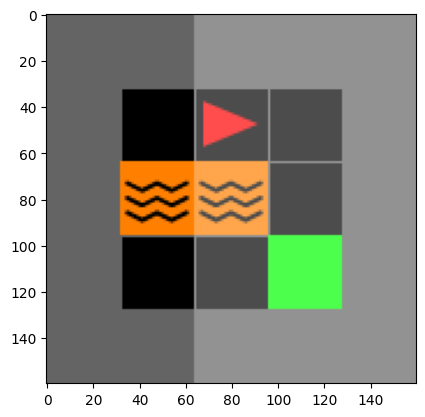

In [12]:
size = 5
seed = 10
env = get_door_key_env(size)
#change this for different sizes
max_episodes = 10000 

## Or crossing env:
env = get_crossing_env(size, Lava)
max_episodes = 10000

Starting 0th eval
Start! Agent: RRR.


  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/8m/r3kmm3xs1lngf9bhwg216mlc0000gn/T/ipykernel_49312/674935607.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs).float() # convert to float tensor


First successful data collected at episode 4! We will be accelerating.
At episode 9, we lost all data in replay buffer...
At episode 10, thirsty explorer collected a successful data.
Solved!


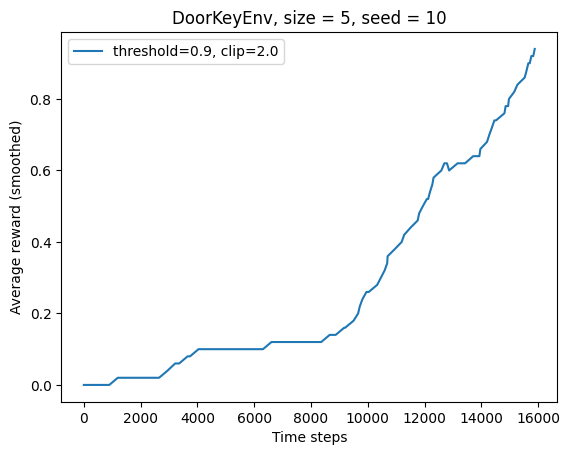

Starting 1th eval
Start! Agent: RRR.


  0%|          | 0/10000 [00:00<?, ?it/s]

First successful data collected at episode 12! We will be accelerating.
Solved!


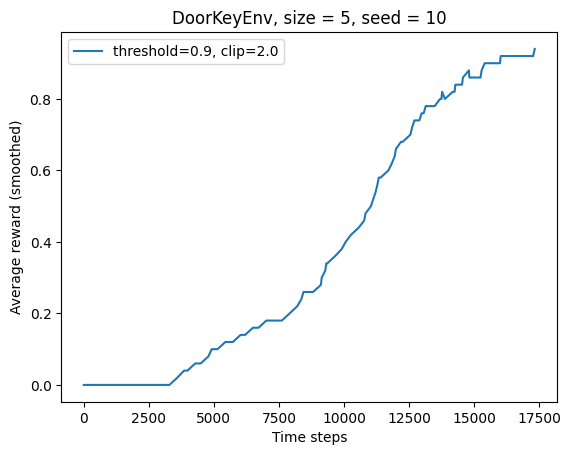

Starting 2th eval
Start! Agent: RRR.


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
for i in range(10):

    print(f"Starting {i}th eval")

    hps = [(0.9, 2.0), (0.8, 2.0), (0.77, 2.0), (0.7, 2.0), (0.6, 2.0), (0.5, 2.0)]
    agents = []
    logs = []

    for hp in hps:
        agent = RRR(ACModel, env=env, args=Config(bad_fit_threshold=hp[0], importance_sampling_clip=hp[1]), seed=seed)
        agents.append(agent)

    for agent in agents:
        num_frames, smooth_rs, fits = agent.train(max_episodes)
        logs.append((num_frames, smooth_rs, fits))

    plt.figure()
    for j in range(len(hps)):
        log = logs[j]
        plt.plot(log[0], log[1], label=f'threshold={hps[j][0]}, clip={hps[j][1]}')
        
    plt.xlabel('Time steps')
    plt.ylabel('Average reward (smoothed)')
    plt.title(f'DoorKeyEnv, size = {size}, seed = {seed}')
    plt.legend()
    plt.show()